In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [52]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [53]:
# Transform data

# Map age group to integer
avg_age_mapping = {
    '0-14': 7,
    '15-24': 20,
    '25-44': 33,
    '45-64': 55,
    '65+': 75
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['average_age'] = df['age'].map(avg_age_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Convert the specified columns to floats
df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
    'dec_tobacco_supply', 'dec_smoking_uptake']] = df[['tax_increase', 'outlet_reduction', 
    'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake']].apply(pd.to_numeric, errors='coerce').astype('float')

# Display the updated DataFrame
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc,average_age,gender_idx,ethnicity_idx
1,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725,7.0,0.0,1.0
2,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675,20.0,0.0,1.0
3,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,7.0,0.0,0.0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314,33.0,0.0,1.0
4,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,1.0,0.0,0.0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181,55.0,0.0,1.0
5,Combined tobacco endgame strategy (tobacco-fre...,10.0,90.0,0.5,0.0,0.0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651,75.0,0.0,1.0


In [54]:
# Define Mean Absolute Percentage Error

def mape(y_actual, y_predicted):
    # Convert inputs to numpy arrays for element-wise operations
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    
    # Ensure y_actual and y_predicted have the same length
    assert len(y_actual) == len(y_predicted)
    
    # Avoid division by zero by excluding zero values in y_actual
    non_zero_indices = y_actual != 0
    
    # Calculate MAPE only on non-zero actual values
    error = np.abs((y_actual[non_zero_indices] - y_predicted[non_zero_indices]) / y_actual[non_zero_indices])
    
    # Return the mean error
    return np.mean(error)

In [71]:
def generate_rf_model(data, bootstrap):
    # Define dependent and independent variables
    X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                            'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                            'gender_idx', 'ethnicity_idx']])

    y = np.array(data[['qalys_pc', 'hs_costs_pc']])

    # Split the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # List of different values of n_estimators to test
    n_estimators_list = list(range(10, 100, 10))
    max_depths_list = list(range(5, 25, 5))
    
    # 2D Array to store MAPE for different n_estimators and values
    mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    
    # Loop over the values of n_estimators and max_depth
    for i in range(len(n_estimators_list)):
        for j in range(len(max_depths_list)):
            # Initialize the RandomForestRegressor with the current n_estimators and max_depth
            rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            
            # Train the model on the training data for QALYs and costs
            rf1.fit(X_train, y_train[:, 0])
            rf2.fit(X_train, y_train[:, 1])
                                        
            # Make predictions on the validation set
            y_pred_qaly = rf1.predict(X_val)
            y_pred_cost = rf2.predict(X_val)

            mape_qaly = mape(y_val[:, 0], y_pred_qaly)
            mape_cost = mape(y_val[:, 1], y_pred_cost)
            
            # Store the relative MAPE in the arrays
            mape_qalys_arr[i][j] = mape_qaly
            mape_costs_arr[i][j] = mape_cost

    # Retrieve best hyperparameters
    qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
    qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
    qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
    hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
    hse_n_estimators = n_estimators_list[hse_min_index[0]]
    hse_max_depth = max_depths_list[hse_min_index[1]]
    
    # Testing using best n_estimators and max_depth
    rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=bootstrap)
    rf1_best.fit(X_train, y_train[:,0])
    rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=bootstrap)
    rf2_best.fit(X_train, y_train[:,1])
    
    # Make predictions on the test set
    qaly_pred = rf1_best.predict(X_test)
    cost_pred = rf2_best.predict(X_test)
    
    # Compute MAPE for each output
    mape_qaly_test = mape(y_test[:, 0], qaly_pred)
    mape_cost_test = mape(y_test[:, 1], cost_pred)

    # Make predictions on training set
    qaly_pred_train = rf1_best.predict(X_train)
    cost_pred_train = rf2_best.predict(X_train)

    # Compute MAPE for training data
    mape_qaly_train = mape(y_train[:, 0], qaly_pred_train)
    mape_cost_train = mape(y_train[:, 1], cost_pred_train)
    
    print(f'n_estimators for QALYs = {qaly_n_estimators}')
    print(f'max_depth for QALYs = {qaly_max_depth}')
    print(f'MAPE for QALYs: {mape_qaly_test}')
    print("----------------------------------")
    print(f'n_estimators for Health System Cost = {hse_n_estimators}')
    print(f'max_depth for Health System Cost = {hse_max_depth}')
    print(f'MAPE for Health System Cost: {mape_cost_test}')

    return rf1_best, mape_qaly_train, mape_qaly_test, rf2_best, mape_cost_train, mape_cost_test

In [82]:
# Set the seed for all random processes globally
np.random.seed(42)

n_duplicated = [1, 3, 5, 8, 10, 15]

numeric_columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'qalys_pc', 'hs_costs_pc']

rf_qaly_bs_ls = []
mape_qaly_train_bs_ls = []
mape_qaly_test_bs_ls = []
rf_cost_bs_ls = []
mape_cost_train_bs_ls = []
mape_cost_test_bs_ls = []

for i in range(len(n_duplicated)):

    # Duplicate the DataFrame
    df_duplicated = pd.concat([df]*n_duplicated[i], ignore_index=True)

    # Add Gaussian noise to the numeric columns with a standard deviation of 0.1
    for col in numeric_columns:
        df_duplicated[col] += np.random.normal(0, 0.1, df_duplicated[col].shape)

    print(f'Dataset with {n_duplicated[i]} duplicates:')
    rf_qaly, mape_qaly_train, mape_qaly_test, rf_cost, mape_cost_train, mape_cost_test = generate_rf_model(df_duplicated, bootstrap=True)
    rf_qaly_bs_ls.append(rf_qaly)
    mape_qaly_train_bs_ls.append(mape_qaly_train)
    mape_qaly_test_bs_ls.append(mape_qaly_test)
    rf_cost_bs_ls.append(rf_cost)
    mape_cost_train_bs_ls.append(mape_cost_train)
    mape_cost_test_bs_ls.append(mape_cost_test)
    print("")


Dataset with 1 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 15
MAPE for QALYs: 0.6954359467547239
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 10
MAPE for Health System Cost: 7.778876262882238

Dataset with 3 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 10
MAPE for QALYs: 0.7761092589735102
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 20
MAPE for Health System Cost: 4.499122861708941

Dataset with 5 duplicates:
n_estimators for QALYs = 90
max_depth for QALYs = 20
MAPE for QALYs: 0.3154976969161919
----------------------------------
n_estimators for Health System Cost = 50
max_depth for Health System Cost = 15
MAPE for Health System Cost: 1.6262163392463815

Dataset with 8 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 15
MAPE for QALYs: 0.16628265345857765
----------------------------------
n_estimators for 

In [83]:
n_duplicated = [1, 3, 5, 8, 10, 15]

# Set the seed for reproducibility
np.random.seed(42)

numeric_columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'qalys_pc', 'hs_costs_pc']

rf_qaly_norep_ls = []
mape_qaly_train_norep_ls = []
mape_qaly_test_norep_ls = []
rf_cost_norep_ls = []
mape_cost_train_norep_ls = []
mape_cost_test_norep_ls = []

for i in range(len(n_duplicated)):
    # Duplicate the DataFrame
    df_duplicated = pd.concat([df]*n_duplicated[i], ignore_index=True)

    # Add Gaussian noise to the numeric columns with a standard deviation of 0.1
    for col in numeric_columns:
        df_duplicated[col] += np.random.normal(0, 0.1, df_duplicated[col].shape)

    print(f'Dataset with {n_duplicated[i]} duplicates:')
    rf_qaly, mape_qaly_train, mape_qaly_test, rf_cost, mape_cost_train, mape_cost_test = generate_rf_model(df_duplicated, bootstrap=False)
    rf_qaly_norep_ls.append(rf_qaly)
    mape_qaly_train_norep_ls.append(mape_qaly_train)
    mape_qaly_test_norep_ls.append(mape_qaly_test)
    rf_cost_norep_ls.append(rf_cost)
    mape_cost_train_norep_ls.append(mape_cost_train)
    mape_cost_test_norep_ls.append(mape_cost_test)
    print("")

Dataset with 1 duplicates:
n_estimators for QALYs = 80
max_depth for QALYs = 5
MAPE for QALYs: 1.3826257728170013
----------------------------------
n_estimators for Health System Cost = 20
max_depth for Health System Cost = 15
MAPE for Health System Cost: 2.4883216520654234

Dataset with 3 duplicates:
n_estimators for QALYs = 30
max_depth for QALYs = 10
MAPE for QALYs: 0.2198453620090991
----------------------------------
n_estimators for Health System Cost = 20
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.05639139064830264

Dataset with 5 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 15
MAPE for QALYs: 0.2540872753435072
----------------------------------
n_estimators for Health System Cost = 40
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.001845673547502993

Dataset with 8 duplicates:
n_estimators for QALYs = 90
max_depth for QALYs = 15
MAPE for QALYs: 0.20223675254201384
----------------------------------
n_estimators 

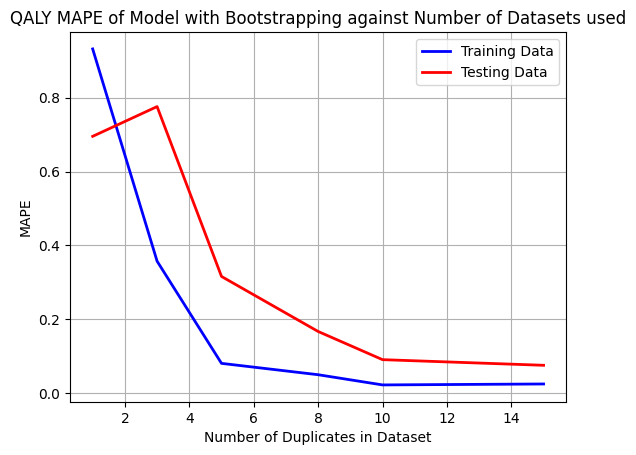

In [88]:
plt.plot(n_duplicated, mape_qaly_train_bs_ls, label='Training Data', color='b', linewidth=2)
plt.plot(n_duplicated, mape_qaly_test_bs_ls, label='Testing Data', color='r', linewidth=2)

# Add labels and title
plt.xlabel('Number of Duplicates in Dataset')
plt.ylabel('MAPE')
plt.title('QALY MAPE of Model with Bootstrapping against Number of Datasets used')
plt.legend() 
plt.grid()  

# Show the plot
plt.show()

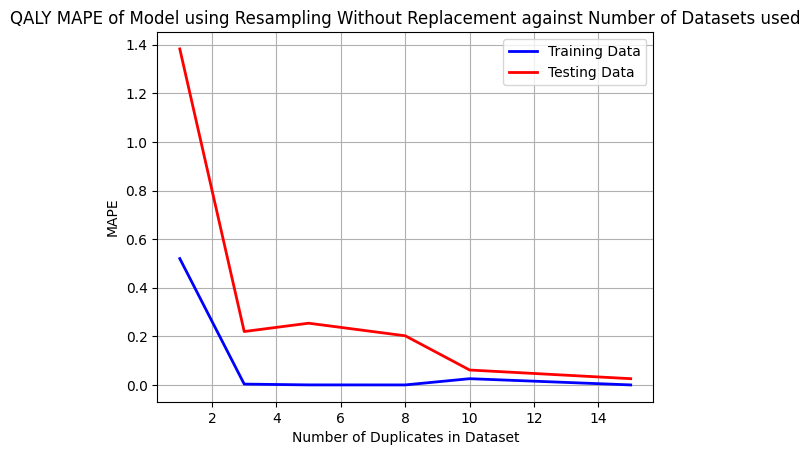

In [90]:
plt.plot(n_duplicated, mape_qaly_train_norep_ls, label='Training Data', color='b', linewidth=2)
plt.plot(n_duplicated, mape_qaly_test_norep_ls, label='Testing Data', color='r', linewidth=2)

# Add labels and title
plt.xlabel('Number of Duplicates in Dataset')
plt.ylabel('MAPE')
plt.title('QALY MAPE of Model using Resampling Without Replacement against Number of Datasets used')
plt.legend()  
plt.grid()  

# Show the plot
plt.show()

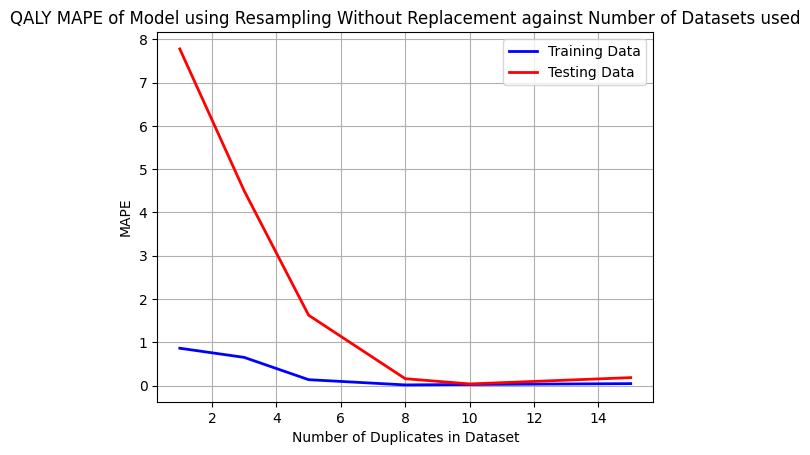

In [91]:
plt.plot(n_duplicated, mape_cost_train_bs_ls, label='Training Data', color='b', linewidth=2)
plt.plot(n_duplicated, mape_cost_test_bs_ls, label='Testing Data', color='r', linewidth=2)  # Plot cosine wave

# Add labels and title
plt.xlabel('Number of Duplicates in Dataset')
plt.ylabel('MAPE')
plt.title('Health System Cost Savings MAPE of Model using Bootstrapping against Number of Datasets used')
plt.legend()  # Show legend to distinguish the lines
plt.grid()  # Add a grid for better readability

# Show the plot
plt.show()

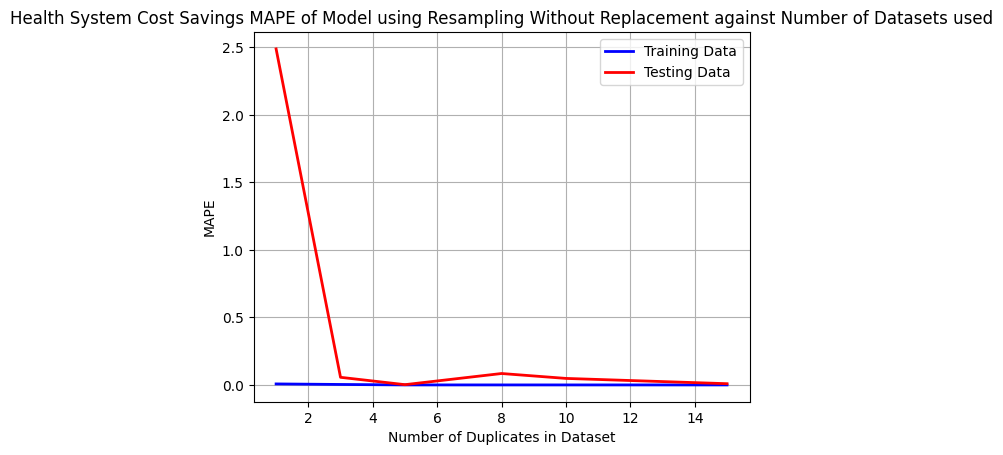

In [92]:
plt.plot(n_duplicated, mape_cost_train_norep_ls, label='Training Data', color='b', linewidth=2)
plt.plot(n_duplicated, mape_cost_test_norep_ls, label='Testing Data', color='r', linewidth=2)  # Plot cosine wave

# Add labels and title
plt.xlabel('Number of Duplicates in Dataset')
plt.ylabel('MAPE')
plt.title('Health System Cost Savings MAPE of Model using Resampling Without Replacement against Number of Datasets used')
plt.legend()  # Show legend to distinguish the lines
plt.grid()  # Add a grid for better readability

# Show the plot
plt.show()

In [93]:
def generate_rf_model_cv(data, bootstrap):
    # Define dependent and independent variables
    X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                       'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                       'gender_idx', 'ethnicity_idx']])

    y = np.array(data[['qalys_pc', 'hs_costs_pc']])

    # List of different values of n_estimators and max_depth to test
    n_estimators_list = list(range(10, 100, 10))
    max_depths_list = list(range(5, 25, 5))
    
    # 2D Array to store MAPE for different n_estimators and values
    mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))

    # KFold cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the values of n_estimators and max_depth
    for i in range(len(n_estimators_list)):
        for j in range(len(max_depths_list)):
            # Initialize the RandomForestRegressor with the current n_estimators and max_depth
            rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)

            mape_qaly_fold = []
            mape_cost_fold = []

            # Perform cross-validation
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # Train the model on the training data for QALYs and costs
                rf1.fit(X_train, y_train[:, 0])
                rf2.fit(X_train, y_train[:, 1])

                # Make predictions on the validation set
                y_pred_qaly = rf1.predict(X_val)
                y_pred_cost = rf2.predict(X_val)

                mape_qaly_fold.append(mape(y_val[:, 0], y_pred_qaly))
                mape_cost_fold.append(mape(y_val[:, 1], y_pred_cost))

            # Store the average MAPE for the current configuration
            mape_qalys_arr[i][j] = np.mean(mape_qaly_fold)
            mape_costs_arr[i][j] = np.mean(mape_cost_fold)

    # Retrieve best hyperparameters
    qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
    qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
    qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
    hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
    hse_n_estimators = n_estimators_list[hse_min_index[0]]
    hse_max_depth = max_depths_list[hse_min_index[1]]
    
    # Training using best n_estimators and max_depth with cross-validation
    rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=bootstrap)
    rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=bootstrap)
    
    # Fit the best models on the entire dataset
    rf1_best.fit(X, y[:, 0])
    rf2_best.fit(X, y[:, 1])

    # Make predictions on the entire dataset for final evaluation
    qaly_pred = rf1_best.predict(X)
    cost_pred = rf2_best.predict(X)

    # Compute MAPE for the entire dataset
    mape_qaly_final = mape(y[:, 0], qaly_pred)
    mape_cost_final = mape(y[:, 1], cost_pred)

    print(f'n_estimators for QALYs = {qaly_n_estimators}')
    print(f'max_depth for QALYs = {qaly_max_depth}')
    print(f'MAPE for QALYs: {mape_qaly_final}')
    print("----------------------------------")
    print(f'n_estimators for Health System Cost = {hse_n_estimators}')
    print(f'max_depth for Health System Cost = {hse_max_depth}')
    print(f'MAPE for Health System Cost: {mape_cost_final}')

    return rf1_best, rf2_best, mape_qaly_final, mape_cost_final

In [100]:
df_dup = pd.concat([df]*1, ignore_index=True)

# Set the seed for reproducibility
np.random.seed(42)

numeric_columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                   'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'qalys_pc', 'hs_costs_pc']

# Add Gaussian noise to the numeric columns with a standard deviation of 0.1
for col in numeric_columns:
    df_dup[col] += np.random.normal(0, 0.1, df_dup[col].shape)

rf1_best, rf2_best, mape_qaly_final, mape_cost_final = generate_rf_model_cv(df_dup, bootstrap=True)

n_estimators for QALYs = 70
max_depth for QALYs = 20
MAPE for QALYs: 0.8246346756260461
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 15
MAPE for Health System Cost: 2.4622074050293095


In [37]:
def display_importance(model):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                                'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                                'gender_idx', 'ethnicity_idx'],
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    
    # Add labels to the bars
    for bar in bars:
        plt.text(
            bar.get_width() + 0.001, 
            bar.get_y() + bar.get_height()/2,  
            f'{bar.get_width():.4f}', 
            va='center'
        )
    
    # Add labels and title
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in RandomForestRegressor')
    plt.gca().invert_yaxis()
    
    # Show the plot
    plt.show()